In [1]:
import functions_idealized
import functions_grid
import functions_realistic
import scipy as sc, scipy.io
import numpy as np
import colormap_ibcao

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ibcao_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x_ibcao = ibcao_file.variables['x'][:]
y_ibcao = ibcao_file.variables['y'][:]
z_ibcao = ibcao_file.variables['z'][:]
xl=-1750e3; xr=-1050e3; yb=1300e3; yt=2000e3
xmin = np.where(x_ibcao==xl)[0][0]
xmax = np.where(x_ibcao==xr)[0][0]
ymin = np.where(y_ibcao==yb)[0][0]
ymax = np.where(y_ibcao==yt)[0][0]
x_region = x_ibcao[xmin:xmax]
y_region = y_ibcao[ymin:ymax]
z_region = z_ibcao[ymin:ymax, xmin:xmax]

# 1. Idealized Bathymetry 

In [3]:
xsize = 76
ysize = 101

In [4]:
w_break, w_mid, w_head, width_f, x_wall, mouth, length, y_wall_1300, y_wall, adjust, cR, L, y_base, y_break,\
y_coast, y_head, fluid_depth, z_bottom, z_break, z_wall, p = functions_idealized.define_Mackenzie_measurements()

x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall, y_wall)

bathymetry = functions_idealized.make_topo_smooth(y_edge, y_base, y_break, y_head, y_coast, cR, L,
                                             x, x_wall, w_break, w_mid, w_head, p,
                                             fluid_depth, z_bottom, z_break, z_wall)

(100, 75)


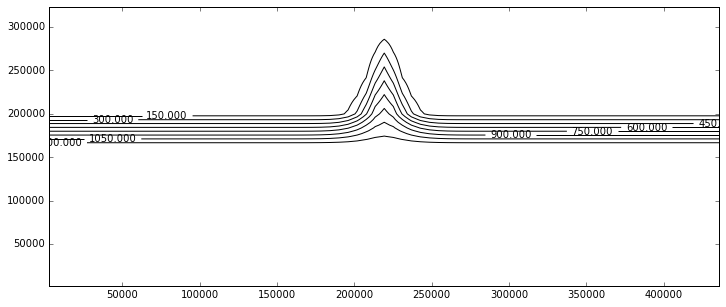

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(12,5))
cs = ax.contour(X, Y, bathymetry, 10, colors='k', linestyles='solid')
CS = ax.contour(X, Y, bathymetry, levels = [-1300, -80, -60, -40.1], colors='k',linestyles='-')
ax.clabel(cs, inline=1); ax.clabel(CS, inline=1)
print(bathymetry.shape)

# 2. Domain Boundaries

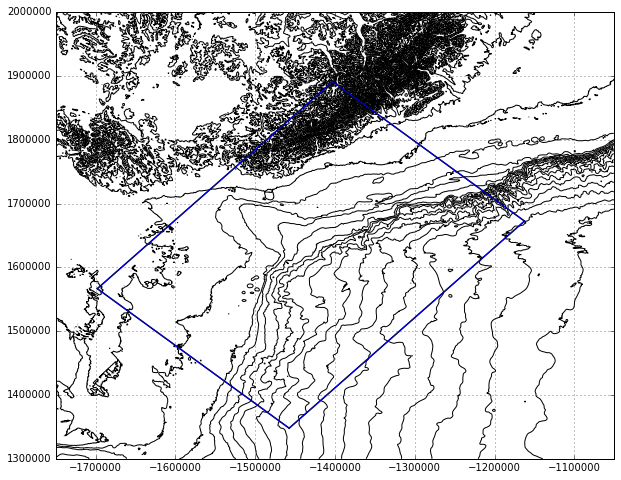

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8)); ax.grid()
ax.contour(x_region, y_region, z_region, 25, colors='k', linestyles='solid')
ax.contour(x_region, y_region, z_region, levels = [-80, -40.1], colors='k', linestyles='-')

search_x = [-1100000, -1450000, -1750000, -1400000]
corner_lons_s, corner_lats_s, ax = functions_grid.match_domain(x_wall, y_wall, search_x, ax)
ax.plot(corner_lons_s, corner_lats_s, 'b')
ax.plot(corner_lons_s[0::3], corner_lats_s[0::3], 'b')

In [9]:
corner_lons_s, corner_lats_s

([-1162500.0, -1403000.0, -1698000.0, -1457500.0],
 [1672500.0, 1891000.0, 1566500.0, 1348000.0])

In [10]:
corner_lons_g, corner_lats_g = functions_grid.transform_coords(corner_lons_s, corner_lats_s, 'SG')
corner_lons_g, corner_lats_g

AttributeError: 'list' object has no attribute 'shape'

# 3. Coordinate Grid

In [2]:
nx = 100; ny = 75
lon = [-132.68103, -143.19904, -132.76558, -144.78392] 
lat = [69.181847, 68.805038, 71.980515, 71.536087]

In [3]:
lon_g_grid, lat_g_grid = functions_grid.create_grid(nx, ny, lon, lat)

In [5]:
lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

(100, 75)


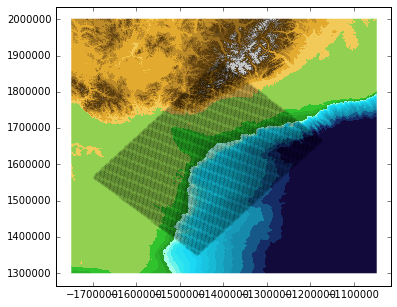

In [8]:
fig, ax = plt.subplots(1,1,figsize=(6,5))
cmap, norm = colormap_ibcao.Colormap()
levels = [-3000, -2000, -1000, 0, 1000, 2000]
ax.pcolorfast(x_region, y_region, z_region, vmin = levels[0], vmax = levels[-1], cmap = cmap)
ax.scatter(lon_s_grid, lat_s_grid, c='k', s=5, alpha=0.1)

print(lon_s_grid.shape)

# 4. Realistic Bathymetry

In [9]:
extension = 20
interp_method = 'linear'
z_positive = functions_realistic.positive_canyon(fluid_depth, extension, lon_s_grid, lat_s_grid, x_region, y_region, z_region, interp_method)

(75, 120)


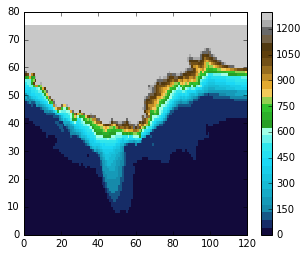

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,4))
c = ax.pcolormesh(z_positive, cmap = cmap)
fig.colorbar(c, ax = ax)
print(z_positive.shape)

# D. Coordinate Grid 2

In [13]:
dx = functions_grid.find_dx(lon_g_grid, lat_g_grid)
extension_m = dx * 1000 * extension
extension_m

84811.862479001546